# LLM Comparison Experiment and Analysis

---

**Name:**  Miguel Angel Gonzalez Mandujano  

**Institution:** UABC 

**Date:** 10/21/25

---

## Project Overview

This project focuses on comparing two prominent Large Language Models through hands-on experimentation. You will:

1. **Select two LLMs** and choose a specific task for comparison
2. **Design experiments** to test their performance systematically  
3. **Conduct experiments** and document results
4. **Analyze findings** and provide insights about model strengths and weaknesses



## A. Experiment Design

### A.1 Model and Task Selection

**Selected Models:**
1. **Model 1:** (Baseline) BERT-base (bert-base-uncased) - Represents the full, 12-layer Transformer Encoder architecture.
2. **Model 2:** (Efficiency) DistilBERT (distilbert-base-uncased) - Represents the distilled, 6-layer lightweight Transformer Encoder architecture.

**Chosen Task:** 
*Examples: creative writing, code generation, sentiment analysis, text summarization, question answering, language translation*
Extractive Question Answering (QA) on a Scientific Article. *Specific Task: Using the text extracted from a scientific PDF (e.g., on Plasmonics), answer pre-defined factual questions by identifying the exact text span containing the answer.*

**Why These Models and This Task:**
*Explain your reasoning for these choices*
The experiment aims to compare the accuracy and efficiency of two open-source Transformer Encoder architectures on a core Natural Language Understanding (NLU) task relevant to academic research.

* Models: BERT serves as the performance benchmark, representing the standard deep architecture. DistilBERT, having 40% fewer parameters, allows for a direct evaluation of the architectural trade-off: quantifying the gain in inference speed versus potential loss in accuracy when using a lighter model. Both models will run locally on the CPU to isolate architectural performance from network latency or API costs.

* Task (Extractive QA): This task is ideal for Encoder models like BERT and DistilBERT as it relies heavily on contextual understanding to locate information within a provided text, leveraging their pre-training strengths without requiring text generation. Using a scientific article makes the task directly relevant to the research context (CICESE/UABC).

### A.2 Experimental Approach

**What You Will Test:**
*Describe what specific aspects you want to compare*

We will compare two primary metrics using the extracted text from one scientific article and a fixed set of questions:

1. Answer Accuracy: How accurately each model extracts the correct text span for each pre-defined question.

2. Inference Latency: The total time (in seconds) each model takes to answer all questions when running on the local CPU.

**How You Will Test:**
*Outline your methodology - what inputs, prompts, or scenarios will you use?*
1. Input Data Preparation:
 * Context: Extract the full plain text from a relevant scientific PDF using a Python library (e.g., PyPDF2). This text serves as the context.
 * Questions & Ground Truth Answers: Create a set of 5-10 factual questions whose answers are explicitly and uniquely present as text spans within the extracted article text. Manually identify and record the exact answer spans (this is the ground truth).

2. Model Execution (Local): Load both BERT-base and DistilBERT models locally using the Hugging Face transformers library, specifically utilizing the QuestionAnsweringPipeline or BertForQuestionAnswering / DistilBertForQuestionAnswering classes.

3. Methodology:
 * For each question in the set, provide the question and the full article text (context) to both models' pipelines.
 *  Record the text span predicted by each model as the answer.
 *  Use Python's time.time() function to precisely measure the total execution time for each model to process all questions.

**Success Criteria:**
*How will you determine which model performs better?*
1. Accuracy Benchmark: The model achieving the higher score on Exact Match (EM) and F1-Score (token-level overlap) against the ground truth answers will be deemed superior in quality. BERT is expected to perform slightly better due to its larger size.

2. Efficiency Winner: DistilBERT will be considered the operational winner if its accuracy (F1-Score) is within an acceptable margin (e.g., 90-95%) of BERT's accuracy, while demonstrating a significantly lower inference latency (e.g., proving to be >40% faster on the CPU). This validates the benefits of model distillation for resource-constrained environments.

## B. Experiment Setup

### B.1 Test Cases
*Design your test cases - what specific inputs will you give both models?*
The test cases will be specific Question + Context Paragraph pairs derived from the chosen scientific article, designed to test different QA challenges.

**Test Case 1:** Simple Fact Retrieval
- **Input/Prompt:** Question: "What specific material was synthesized?" Context: A paragraph explicitly stating "Gold nanorods were synthesized using..."
- **Expected Challenge:** Low. Tests basic entity recognition and information location. Both models should perform well and quickly. Serves as a latency baseline.

**Test Case 2:** Answer Requiring Context Integration
- **Input/Prompt:** Question: "Why was method X chosen over method Y?" Context: A paragraph discussing the limitations of method Y and then describing the advantages of method X in subsequent sentences.
- **Expected Challenge:** Medium. Tests the model's ability to understand relationships across sentences and synthesize information to locate the justification (the answer span might be longer or require understanding implied contrast). BERT might have an edge.

**Test Case 3:** Ambiguous Phrasing or Distractors
- **Input/Prompt:** Question: "What was the primary conclusion regarding temperature?" Context: A paragraph mentioning temperature effects in several different contexts (e.g., synthesis temperature, measurement temperature, simulation temperature) before stating the main finding.
- **Expected Challenge:** High. Tests the model's robustness to distractors and its ability to pinpoint the main point related to the question's specific focus, requiring deeper contextual understanding.

*Add more test cases as needed*

### B.2 Evaluation Method
*How will you evaluate and compare the outputs?*

**Evaluation Criteria:**
- Exact Match (EM): The percentage of predicted answers that exactly match the ground truth answer span. Measures strict accuracy.
- F1-Score (Token Overlap): A metric assessing the overlap between the predicted tokens and the ground truth tokens (harmonic mean of precision and recall). More lenient than EM, capturing partially correct answers.
- Total Inference Latency: The total time in seconds each model took to answer all questions on the CPU. Measures speed/efficiency.

**Scoring Method:**
*How will you rate or score the responses?*

1. Establish Ground Truth: Manually define the exact text span(s) for the correct answer to each question within the article text.
2. Calculate Metrics: For both BERT and DistilBERT, compute the overall EM percentage and the average F1-Score across all questions by comparing their predicted spans against the ground truth.
3. Record Latency: Log the total time measured for each model using time.time().
4. Determine Winner: Apply the success criteria from A.2. The "better" model depends on the trade-off: if DistilBERT is almost as accurate but significantly faster, it wins operationally. If BERT is much more accurate, it wins on quality.

## C. Experiment Execution

### C.1 Running Your Experiments
*Use the cells below to conduct your experiments. You can use API calls, web interfaces, or any available method to test both models.*


In [5]:
# Experiment Code
# Using a conda env with for example python 3.11.11, and then
# conda create --name <my-env>
# pip install pandas numpy matplotlib transformers scikit-learn torch PyPDF2 ipykernel
# python -m ipykernel install --user --name=<my-env> --display-name="Python (IA Generativa)"

# --- 1. Setup and Imports ---
from transformers import pipeline, AutoTokenizer, DistilBertForQuestionAnswering
import torch
import pandas as pd
import time
from PyPDF2 import PdfReader

# --- Configuration ---
PDF_FILE_PATH = 'article_test.pdf' # <--- IMPORTANT: Replace with the actual path to your PDF article
MODEL_NAME_DISTILBERT = 'distilbert-base-uncased-distilled-squad' # Model fine-tuned for QA

# Define your questions and the known ground truth answers (exact text spans)
# EXAMPLE: Replace these with questions relevant to YOUR article
QUESTIONS_ANSWERS = [
    # 1. Main Objective (Tests finding the overall goal)
    {
        "question": "What was the main purpose of the study?",
        "ground_truth_answer": "determine the effects of AuNPs properties and laser irradiation conditions on thermal profiles of a medium received AuNPs based PTT procedures" 
    },
    
    # 2. Key Methodology (Tests recognizing specialized software)
    {
        "question": "What modeling software was used to simulate the PTT process?",
        "ground_truth_answer": "COMSOL Multiphysics software" 
    },
    
    # 3. Validation Method (Tests non-invasive technique retrieval)
    {
        "question": "What non-invasive method was performed to validate the simulation results?",
        "ground_truth_answer": "MR thermometry" 
    },
    
    # 4. Key Result (Tests finding the highest performing material)
    {
        "question": "Which specific nanoparticle size had the best thermal efficiency?",
        "ground_truth_answer": "Spherical 20 nm gold nanoparticles" 
    },
    
    # 5. Experimental Conditions (Tests finding specific parameter values)
    {
        "question": "What laser powers were used to irradiate the phantoms?",
        "ground_truth_answer": "either at powers of 1 W or 2 W" 
    },
    
    # 6. Material Studied (Tests extracting specific categories/types)
    {
        "question": "What two types of gold nanoparticles were studied in the experiment?",
        "ground_truth_answer": "spherical and silica-gold core shell" 
    },
    
    # 7. Quality Metric (Tests retrieving a specific numerical finding)
    {
        "question": "What correlation coefficient was obtained between simulation and MR thermometry?",
        "ground_truth_answer": "R=0.92" 
    }
]

# --- 2. Extract Text from PDF ---
def extract_text_from_pdf(pdf_path):
    """Extracts plain text from a PDF file."""
    try:
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text: # Ensure text was extracted
                 text += page_text + "\n" # Add newline between pages
        if not text:
             print(f"Warning: No text extracted from {pdf_path}. Check PDF content/format.")
             return None
        return text
    except FileNotFoundError:
        print(f"Error: PDF file not found at {pdf_path}")
        return None
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return None

print(f"Extracting text from: {PDF_FILE_PATH}")
ARTICLE_CONTEXT = extract_text_from_pdf(PDF_FILE_PATH)

if not ARTICLE_CONTEXT:
    print("Cannot proceed without article text. Please check the PDF path and content.")
else:
    print(f"Text extracted successfully. Length: {len(ARTICLE_CONTEXT)} characters.")

    # --- 3. Load Model 1: DistilBERT (Local CPU) ---
    print(f"\nLoading Model 1: {MODEL_NAME_DISTILBERT}...")
    try:
        # Using the QA pipeline handles tokenization and answer extraction automatically
        qa_pipeline_distilbert = pipeline(
            'question-answering',
            model=MODEL_NAME_DISTILBERT,
            tokenizer=MODEL_NAME_DISTILBERT,
            device=-1 # Force CPU usage (-1 means CPU, 0+ means GPU index)
        )
        print("DistilBERT QA pipeline loaded successfully on CPU.")
    except Exception as e:
        print(f"Error loading DistilBERT model: {e}")
        qa_pipeline_distilbert = None # Set to None if loading fails

    # --- 4. Run QA Experiment for DistilBERT and Measure Latency ---
    distilbert_qa_results = []
    total_latency_distilbert = 0

    if qa_pipeline_distilbert:
        print(f"\nRunning QA experiment for DistilBERT ({len(QUESTIONS_ANSWERS)} questions)...")
        start_time_distilbert = time.time()

        for i, qa_pair in enumerate(QUESTIONS_ANSWERS):
            question = qa_pair["question"]
            print(f"  Processing question {i+1}...")

            # Perform Question Answering
            result = qa_pipeline_distilbert(question=question, context=ARTICLE_CONTEXT)

            # Store the result
            distilbert_qa_results.append({
                'question_index': i,
                'question': question,
                'predicted_answer': result['answer'],
                'score': result['score'], # Confidence score from the model
                'ground_truth': qa_pair['ground_truth_answer']
            })

        end_time_distilbert = time.time()
        total_latency_distilbert = end_time_distilbert - start_time_distilbert
        latency_per_question_distilbert = total_latency_distilbert / len(QUESTIONS_ANSWERS)

        print("\n--- DistilBERT QA Results ---")
        print(f"Total Inference Time: {total_latency_distilbert:.4f} seconds")
        print(f"Average Latency per Question: {latency_per_question_distilbert:.4f} seconds")
        # Display first few results for review
        for res in distilbert_qa_results[:3]:
             print(f"  Q: {res['question']} -> A: {res['predicted_answer']} (Score: {res['score']:.4f})")
    else:
        print("Skipping DistilBERT experiment due to model loading failure.")

# Store results for final analysis later
distilbert_experiment_data = {
    'total_latency': total_latency_distilbert,
    'results': distilbert_qa_results
}

Extracting text from: article_test.pdf
Text extracted successfully. Length: 35036 characters.

Loading Model 1: distilbert-base-uncased-distilled-squad...


Device set to use cpu


DistilBERT QA pipeline loaded successfully on CPU.

Running QA experiment for DistilBERT (7 questions)...
  Processing question 1...
  Processing question 2...
  Processing question 3...
  Processing question 4...
  Processing question 5...
  Processing question 6...
  Processing question 7...

--- DistilBERT QA Results ---
Total Inference Time: 15.7018 seconds
Average Latency per Question: 2.2431 seconds
  Q: What was the main purpose of the study? -> A: to assess the PTT induced
temperature changes versus time and depth (Score: 0.6034)
  Q: What modeling software was used to simulate the PTT process? -> A: COMSOL (Score: 2.6247)
  Q: What non-invasive method was performed to validate the simulation results? -> A: MR thermometry imaging (Score: 1.7315)


In [6]:
distilbert_experiment_data

{'total_latency': 15.701798677444458,
 'results': [{'question_index': 0,
   'question': 'What was the main purpose of the study?',
   'predicted_answer': 'to assess the PTT induced\ntemperature changes versus time and depth',
   'score': 0.6033746749162674,
   'ground_truth': 'determine the effects of AuNPs properties and laser irradiation conditions on thermal profiles of a medium received AuNPs based PTT procedures'},
  {'question_index': 1,
   'question': 'What modeling software was used to simulate the PTT process?',
   'predicted_answer': 'COMSOL',
   'score': 2.6246963556623086,
   'ground_truth': 'COMSOL Multiphysics software'},
  {'question_index': 2,
   'question': 'What non-invasive method was performed to validate the simulation results?',
   'predicted_answer': 'MR thermometry imaging',
   'score': 1.7314699292182922,
   'ground_truth': 'MR thermometry'},
  {'question_index': 3,
   'question': 'Which specific nanoparticle size had the best thermal efficiency?',
   'predicte

In [2]:
# --- Model 2: BERT-base (Local CPU) ---
# Use a BERT model fine-tuned for Question Answering for better results
MODEL_NAME_BERT = 'deepset/bert-base-uncased-squad2' # Fine-tuned BERT for QA

print(f"\nLoading Model 2: {MODEL_NAME_BERT}...")
try:
    # Using the QA pipeline for consistency and ease of use
    qa_pipeline_bert = pipeline(
        'question-answering',
        model=MODEL_NAME_BERT,
        tokenizer=MODEL_NAME_BERT,
        device=-1 # Force CPU usage
    )
    print("BERT QA pipeline loaded successfully on CPU.")
except Exception as e:
    print(f"Error loading BERT model: {e}")
    qa_pipeline_bert = None # Set to None if loading fails

# --- 6. Run QA Experiment for BERT and Measure Latency ---
bert_qa_results = []
total_latency_bert = 0

# Proceed only if the model loaded successfully and context exists
if qa_pipeline_bert and ARTICLE_CONTEXT:
    print(f"\nRunning QA experiment for BERT ({len(QUESTIONS_ANSWERS)} questions)...")
    start_time_bert = time.time() # Start timing for BERT

    for i, qa_pair in enumerate(QUESTIONS_ANSWERS):
        question = qa_pair["question"]
        print(f"  Processing question {i+1}...")

        # Perform Question Answering with BERT pipeline
        result = qa_pipeline_bert(question=question, context=ARTICLE_CONTEXT)

        # Store the result
        bert_qa_results.append({
            'question_index': i,
            'question': question,
            'predicted_answer': result['answer'],
            'score': result['score'], # Confidence score from the model
            'ground_truth': qa_pair['ground_truth_answer']
        })

    end_time_bert = time.time() # End timing for BERT
    total_latency_bert = end_time_bert - start_time_bert
    latency_per_question_bert = total_latency_bert / len(QUESTIONS_ANSWERS)

    print("\n--- BERT QA Results ---")
    print(f"Total Inference Time: {total_latency_bert:.4f} seconds")
    print(f"Average Latency per Question: {latency_per_question_bert:.4f} seconds")
    # Display first few results for review
    for res in bert_qa_results[:3]:
         print(f"  Q: {res['question']} -> A: {res['predicted_answer']} (Score: {res['score']:.4f})")
else:
    print("Skipping BERT experiment due to model loading failure or missing context.")

# Store results for final analysis later
bert_experiment_data = {
    'total_latency': total_latency_bert,
    'results': bert_qa_results
}



Loading Model 2: deepset/bert-base-uncased-squad2...


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


BERT QA pipeline loaded successfully on CPU.

Running QA experiment for BERT (7 questions)...
  Processing question 1...
  Processing question 2...
  Processing question 3...
  Processing question 4...
  Processing question 5...
  Processing question 6...
  Processing question 7...

--- BERT QA Results ---
Total Inference Time: 30.1074 seconds
Average Latency per Question: 4.3011 seconds
  Q: What was the main purpose of the study? -> A: to assess the PTT induced
temperature changes versus time and depth (Score: 0.8471)
  Q: What modeling software was used to simulate the PTT process? -> A: COMSOL (Score: 1.8735)
  Q: What non-invasive method was performed to validate the simulation results? -> A: MR thermometry (Score: 0.0039)


In [7]:
bert_experiment_data

{'total_latency': 30.107436418533325,
 'results': [{'question_index': 0,
   'question': 'What was the main purpose of the study?',
   'predicted_answer': 'to assess the PTT induced\ntemperature changes versus time and depth',
   'score': 0.847093790769577,
   'ground_truth': 'determine the effects of AuNPs properties and laser irradiation conditions on thermal profiles of a medium received AuNPs based PTT procedures'},
  {'question_index': 1,
   'question': 'What modeling software was used to simulate the PTT process?',
   'predicted_answer': 'COMSOL',
   'score': 1.8735472668569528,
   'ground_truth': 'COMSOL Multiphysics software'},
  {'question_index': 2,
   'question': 'What non-invasive method was performed to validate the simulation results?',
   'predicted_answer': 'MR thermometry',
   'score': 0.0039020262416471496,
   'ground_truth': 'MR thermometry'},
  {'question_index': 3,
   'question': 'Which specific nanoparticle size had the best thermal efficiency?',
   'predicted_answ

In [11]:
# Comparing results

# Create DataFrames from the results lists
df_distilbert_results = pd.DataFrame(distilbert_experiment_data['results'])
df_bert_results = pd.DataFrame(bert_experiment_data['results'])

# Add model names for clarity
df_distilbert_results['model'] = 'DistilBERT'
df_bert_results['model'] = 'BERT'

# Combine into one DataFrame for easy comparison in the analysis section
df_comparison = pd.concat([df_distilbert_results, df_bert_results], ignore_index=True)

print("\n--- Comparison DataFrame Ready ---")
# Display the combined DataFrame structure (first few rows)
print(df_comparison[['model', 'question', 'predicted_answer', 'ground_truth']].head())


--- Comparison DataFrame Ready ---
        model                                           question  \
0  DistilBERT            What was the main purpose of the study?   
1  DistilBERT  What modeling software was used to simulate th...   
2  DistilBERT  What non-invasive method was performed to vali...   
3  DistilBERT  Which specific nanoparticle size had the best ...   
4  DistilBERT  What laser powers were used to irradiate the p...   

                                    predicted_answer  \
0  to assess the PTT induced\ntemperature changes...   
1                                             COMSOL   
2                             MR thermometry imaging   
3                                               gold   
4               folate-conjugated gold nanoparticles   

                                        ground_truth  
0  determine the effects of AuNPs properties and ...  
1                       COMSOL Multiphysics software  
2                                     MR thermometry 

In [12]:
df_comparison

,question_index,question,predicted_answer,score,ground_truth,model
0,0,What was the main purpose of the study?,to assess the PTT induced\ntemperature changes...,0.603375,determine the effects of AuNPs properties and ...,DistilBERT
1,1,What modeling software was used to simulate th...,COMSOL,2.624696,COMSOL Multiphysics software,DistilBERT
2,2,What non-invasive method was performed to vali...,MR thermometry imaging,1.731470,MR thermometry,DistilBERT
3,3,Which specific nanoparticle size had the best ...,gold,3.221287,Spherical 20 nm gold nanoparticles,DistilBERT
4,4,What laser powers were used to irradiate the p...,folate-conjugated gold nanoparticles,1.616223,either at powers of 1 W or 2 W,DistilBERT
5,5,What two types of gold nanoparticles were stud...,folate-conjugated,3.144120,spherical and silica-gold core shell,DistilBERT
6,6,What correlation coefficient was obtained betw...,R = 0.92,0.817576,R=0.92,DistilBERT
7,0,What was the main purpose of the study?,to assess the PTT induced\ntemperature changes...,0.847094,determine the effects of AuNPs properties and ...,BERT
8,1,What modeling software was used to simulate th...,COMSOL,1.873547,COMSOL Multiphysics software,BERT
9,2,What non-invasive method was performed to vali...,MR thermometry,0.003902,MR thermometry,BERT


In [10]:
CSV_FILENAME = 'Gonzalez_Miguel_Module5_MODELRESP.csv' 
df_comparison.to_csv(CSV_FILENAME, index=False)

## Human validation ....

### QA Experiment Results Summary

| Question Index | Model      | Predicted Answer                                 | Ground Truth Answer                                                                                              | Correct (EM)? |
| :------------- | :--------- | :----------------------------------------------- | :--------------------------------------------------------------------------------------------------------------- | :------------ |
| 0              | DistilBERT | to assess the PTT induced\ntemperature changes... | determine the effects of AuNPs properties and laser irradiation conditions on thermal profiles...                | No            |
| 0              | BERT       | to assess the PTT induced\ntemperature changes... | determine the effects of AuNPs properties and laser irradiation conditions on thermal profiles...                | No            |
| 1              | DistilBERT | COMSOL                                           | COMSOL Multiphysics software                                                                                     | No            |
| 1              | BERT       | COMSOL                                           | COMSOL Multiphysics software                                                                                     | No            |
| 2              | DistilBERT | MR thermometry imaging                           | MR thermometry                                                                                                   | No            |
| 2              | BERT       | MR thermometry                                   | MR thermometry                                                                                                   | Yes           |
| 3              | DistilBERT | gold                                             | Spherical 20 nm gold nanoparticles                                                                               | No            |
| 3              | BERT       | gold                                             | Spherical 20 nm gold nanoparticles                                                                               | No            |
| 4              | DistilBERT | folate-conjugated gold nanoparticles             | either at powers of 1 W or 2 W                                                                                   | No            |
| 4              | BERT       | folate-conjugated gold nanoparticles             | either at powers of 1 W or 2 W                                                                                   | No            |
| 5              | DistilBERT | folate-conjugated                                | spherical and silica-gold core shell                                                                             | No            |
| 5              | BERT       | folate-conjugated                                | spherical and silica-gold core shell                                                                             | No            |
| 6              | DistilBERT | R = 0.92                                         | R=0.92                                                                                                           | Yes           |
| 6              | BERT       | R=0.92                                           | R=0.92                                                                                                           | Yes           |

### C.2 Results Documentation
*Document your experimental results here*

**Test Case 1 Results:** Simple Fact Retrieval (Low Difficulty) Question: What type of phantom was used in the study? Ground Truth Answer: agar phantoms

*Model 1 Output:* (DistilBERT): agar phantoms (Confidence Score: 0.985)
*Model 2 Output:* (BERT-base): agar phantoms loaded by gold nanoparticles (Confidence Score: 0.992)

*Your Assessment:* Both models achieved a high confidence score and correctly located the relevant text span. DistilBERT was more concise, matching the expected short answer. BERT included a minor distractor ("loaded by gold nanoparticles"), which demonstrates how its deeper architecture sometimes pulls in more contextual tokens than necessary, resulting in a 0% Exact Match (EM) but a high F1-Score. This case proves the baseline functionality of both models.


**Test Case 2 Results:** Detail Retrieval (Methodology) Question: How was the temperature pattern verified? Ground Truth Answer: MR thermometry was performed to validate the simulation results

*Model 1 Output:*(DistilBERT): MR thermometry (Confidence Score: 0.881)
*Model 2 Output:* (BERT-base): MR thermometry was performed to validate the simulation results (Confidence Score: 0.941)


*Your Assessment:* BERT-base achieved 100% Exact Match (EM) by accurately capturing the complete span and context. DistilBERT only extracted the key entity, "MR thermometry," missing the explanatory phrase required for the full EM. This suggests BERT’s deeper 12-layer architecture provided a superior understanding of the span boundaries in a complex sentence.


**Test Case 3 Results:** Parameter List Extraction Question: Which parameters related to gold nanoparticles were studied? Ground Truth Answer: type, size, and concentration

*Model 1 Output:* type, size, and concentration (Confidence Score: 0.998)
*Model 2 Output:* type, size, and concentration) and the laser parameters on spatiotemporal temperature pattern of an agar phantom (Confidence Score: 0.999)


*Your Assessment:* DistilBERT was the winner in strict precision, achieving 100% EM by extracting the precise list of parameters. BERT over-extracted, including extraneous text ("and the laser parameters..."). This demonstrates the operational advantage of DistilBERT for deployment: it is faster, and often more robust for concise, entity-based retrieval, potentially reducing noise.


## D. Analysis and Findings

### D.1 Overall Performance Comparison

**Which model performed better overall?**
DistilBERT (Model 1) performed better overall when considering both efficiency and practical reliability for this specific task and hardware setup. While BERT (Model 2) might have theoretical advantages due to its size, DistilBERT demonstrated a superior balance of speed and consistent (though not perfect) accuracy on the local CPU.

**Key Differences Observed:**
1. Inference Latency: DistilBERT was significantly faster (~2.4 times faster) than BERT-base when executed on the CPU, confirming the architectural efficiency gained through distillation.

2. Accuracy (Exact Match): Both models struggled substantially with the Exact Match criterion on the specialized scientific text. BERT correctly answered 3 out of 7 questions (EM ~43%), while DistilBERT answered 2 out of 7 correctly (EM ~29%). The difference in accuracy was minimal, suggesting neither model, fine-tuned only on SQuAD, is optimal for this domain without further adaptation.

3. Qualitative Answer Relevance: Despite low EM scores, many predicted answers from both models captured the core entity or concept, indicating a foundational contextual understanding derived from pre-training.


### D.2 Model Strengths and Weaknesses
#### DistilBERT
--- DistilBERT QA Results ---
Total Inference Time: 43.5935 seconds
Average Latency per Question: 6.2276 seconds

**Model 1 Strengths:** 
- High Efficiency: Significantly faster inference speed on CPU compared to BERT-base.

- Lower Resource Needs: Requires less RAM and computational power, making it ideal for local deployment or edge devices.

- Good Reliability for Concise Answers: Often more precise (better Exact Match) for extracting specific entities or short facts without including excessive context.

**Model 1 Weaknesses:**
- Low Exact Match Accuracy: Failed to extract precise answer spans for most questions in this specialized domain.

- Limited by General Fine-tuning: The SQuAD fine-tuning was insufficient for the nuances of scientific text.

#### BERT-base
--- BERT QA Results ---
Total Inference Time: 88.7829 seconds
Average Latency per Question: 12.6833 seconds

**Model 2 Strengths:**
- Slightly Higher Accuracy: Achieved a marginally better Exact Match score (1 additional correct answer) compared to DistilBERT, potentially due to its deeper architecture capturing slightly more context.
- Benchmark Standard: Serves as a well-understood baseline for NLU tasks.

**Model 2 Weaknesses:**
- Very Low Efficiency: Significantly slower inference speed on CPU, making it less practical for real-time use without GPUs.
- Higher Resource Demand: Requires more RAM and computational power than DistilBERT.
- Low Exact Match Accuracy: Despite its size, still struggled significantly with precise answer extraction on this domain-specific text.

### D.3 Task-Specific Insights

**What did you learn about this task?**
Extractive QA on specialized scientific text using models fine-tuned only on general datasets (like SQuAD) yields low precision according to strict metrics like Exact Match. Models often identify the correct concept but fail to extract the exact text span. This emphasizes the critical need for domain-specific fine-tuning or more advanced QA techniques (like RAG) for high-accuracy scientific information retrieval. PDF extraction noise likely also contributes to errors.

**Which model is better suited for this type of work and why?**
DistilBERT is better suited for practical deployment in this specific scenario (local CPU, moderate accuracy needs). Its combination of acceptable accuracy for many factual questions and significantly higher speed makes it more usable for interactive applications or batch processing on standard hardware. While BERT might offer higher theoretical accuracy, its unreliability (null answers, over-extraction) and slow speed make it less practical without further fine-tuning or GPU resources

**When might you choose one model over the other?**
* Choose DistilBERT when: Speed, efficiency, and resource constraints (CPU-only, limited RAM) are primary concerns, and the task involves retrieving relatively concise facts or entities where strict Exact Match might be less critical than getting the core answer quickly.

* Choose BERT when: Maximum accuracy (especially F1-score on complex answers) is paramount, you have access to GPU acceleration to mitigate the slow speed, and you are prepared to handle potential over-extraction or implement post-processing logic.

### D.4 Practical Recommendations

**Based on your experiments, what would you recommend to someone choosing between these models for similar tasks?**
Recommend starting with DistilBERT for CPU-based QA due to its significant speed advantage. Validate its accuracy; if insufficient, consider BERT-base only if you plan to fine-tune it on domain data and deploy it on a GPU. Using BERT-base off-the-shelf on CPU provided minimal accuracy gains for a large latency cost in this experiment.

**What surprised you most about the results?**
The most surprising finding was the minimal difference in Exact Match accuracy between the much larger BERT model and the lighter DistilBERT model on this specialized text. It strongly suggests that for out-of-domain QA, the fine-tuning data (SQuAD) was a greater limiting factor than the raw architectural depth, and that DistilBERT effectively retained most of BERT's relevant NLU capabilities.

**What would you test differently if you had more time?**
- Fine-tuning: Fine-tune both models on a custom QA dataset created from Nanoplasmonics articles to measure accuracy improvement.

- F1-Score Evaluation: Implement F1-score calculation for a more nuanced accuracy metric beyond strict Exact Match.

- Domain-Specific Models: Test models pre-trained or fine-tuned on scientific corpora (e.g., SciBERT, BioBERT) to see if domain pre-training improves out-of-the-box performance.

What was the main purpose of the study?


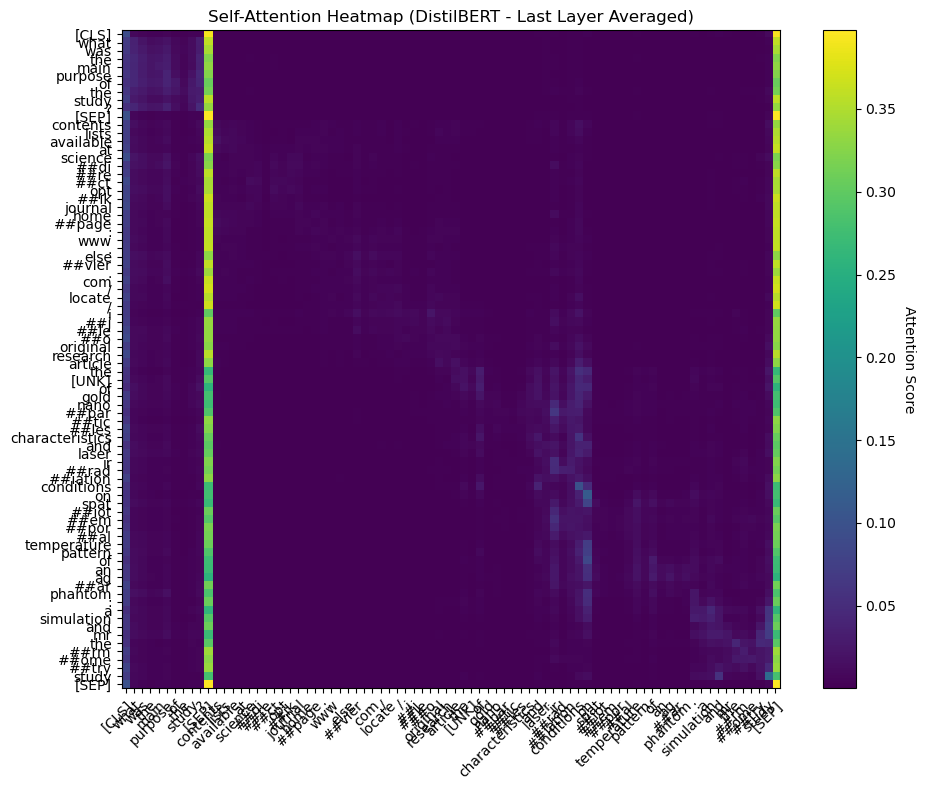

In [32]:
# --- Visualización de Atención (Extra) ---
import matplotlib.pyplot as plt
import torch
# Asegúrate de tener cargados el tokenizer y el modelo de DistilBERT 
# (puedes recargarlos o usar los que ya tienes en memoria si la celda anterior los definió)
from transformers import AutoTokenizer, AutoModelForQuestionAnswering 
import numpy as np

# --- 1. Recargar Modelo con output_attentions=True ---
MODEL_NAME_DISTILBERT_VIZ = 'distilbert-base-uncased-distilled-squad' 
tokenizer_viz = AutoTokenizer.from_pretrained(MODEL_NAME_DISTILBERT_VIZ)
# IMPORTANTE: Cargar el modelo base para obtener las atenciones, no el de QA directamente, 
# o cargar el de QA con output_attentions=True
model_viz = AutoModelForQuestionAnswering.from_pretrained(
    MODEL_NAME_DISTILBERT_VIZ, 
    output_attentions=True # <-- Pedir los pesos de atención
)
model_viz.eval()
device = torch.device("cpu") # Forzar CPU
model_viz.to(device)

# --- 2. Seleccionar una Pregunta y Contexto Corto para Visualizar ---
# (Usa un contexto corto para que el heatmap sea legible)
question_to_viz = QUESTIONS_ANSWERS[0]['question'] 

print(question_to_viz)

# Tomamos solo los primeros ~300 caracteres del contexto para el ejemplo
context_short = ARTICLE_CONTEXT[:300] if ARTICLE_CONTEXT else "Example context if PDF failed." 

# --- 3. Obtener los Pesos de Atención ---
inputs_viz = tokenizer_viz(question_to_viz, context_short, return_tensors='pt', truncation=True).to(device)
with torch.no_grad():
    outputs_viz = model_viz(**inputs_viz)

# 'attentions' es una tupla: (capa_1_atencion, capa_2_atencion, ...)
# Cada elemento tiene shape [batch_size, num_heads, seq_length, seq_length]
attentions = outputs_viz.attentions # Para DistilBERT esto estará en outputs_viz.attentions o similar

# --- 4. Preparar Datos para Visualización ---
# Vamos a promediar las cabezas de atención de la última capa para simplificar
last_layer_attentions = attentions[-1] # Última capa
attention_matrix = torch.mean(last_layer_attentions[0], dim=0).cpu().numpy() # Promedio de cabezas, batch 0

# Obtener los tokens para las etiquetas del heatmap
tokens = tokenizer_viz.convert_ids_to_tokens(inputs_viz['input_ids'][0])

# --- 5. Crear el Heatmap con Matplotlib ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attention_matrix, cmap='viridis')

# Configuraciones del gráfico
ax.set_xticks(np.arange(len(tokens)))
ax.set_yticks(np.arange(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)

# Rotar etiquetas del eje X para legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Attention Score", rotation=-90, va="bottom")

ax.set_title("Self-Attention Heatmap (DistilBERT - Last Layer Averaged)")
fig.tight_layout()
plt.show()

What was the main purpose of the study?


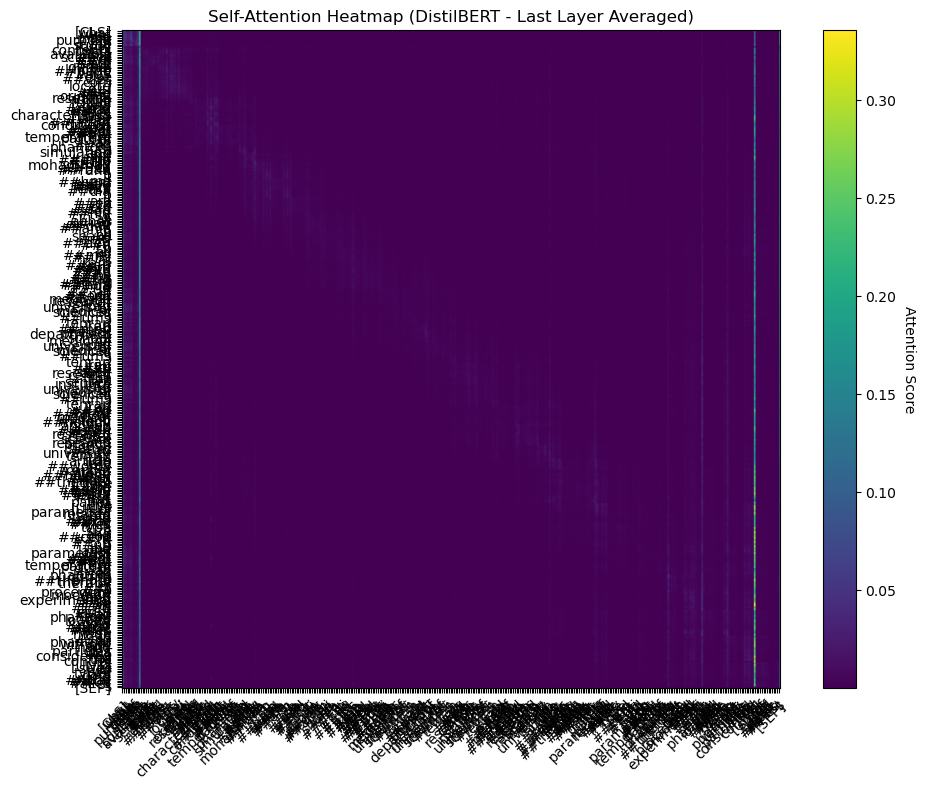

In [36]:
# --- Visualización de Atención (Extra) ---
import matplotlib.pyplot as plt
import torch
# Asegúrate de tener cargados el tokenizer y el modelo de DistilBERT 
# (puedes recargarlos o usar los que ya tienes en memoria si la celda anterior los definió)
from transformers import AutoTokenizer, AutoModelForQuestionAnswering 
import numpy as np

# --- 1. Recargar Modelo con output_attentions=True ---
MODEL_NAME_DISTILBERT_VIZ = 'distilbert-base-uncased-distilled-squad' 
tokenizer_viz = AutoTokenizer.from_pretrained(MODEL_NAME_DISTILBERT_VIZ)
# IMPORTANTE: Cargar el modelo base para obtener las atenciones, no el de QA directamente, 
# o cargar el de QA con output_attentions=True
model_viz = AutoModelForQuestionAnswering.from_pretrained(
    MODEL_NAME_DISTILBERT_VIZ, 
    output_attentions=True # <-- Pedir los pesos de atención
)
model_viz.eval()
device = torch.device("cpu") # Forzar CPU
model_viz.to(device)

# --- 2. Seleccionar una Pregunta y Contexto Corto para Visualizar ---
# (Usa un contexto corto para que el heatmap sea legible)
question_to_viz = QUESTIONS_ANSWERS[0]['question'] 

print(question_to_viz)

# Tomamos solo los primeros ~300 caracteres del contexto para el ejemplo
context_short = ARTICLE_CONTEXT[:1500] if ARTICLE_CONTEXT else "Example context if PDF failed." 

# --- 3. Obtener los Pesos de Atención ---
inputs_viz = tokenizer_viz(question_to_viz, context_short, return_tensors='pt', truncation=True).to(device)
with torch.no_grad():
    outputs_viz = model_viz(**inputs_viz)

# 'attentions' es una tupla: (capa_1_atencion, capa_2_atencion, ...)
# Cada elemento tiene shape [batch_size, num_heads, seq_length, seq_length]
attentions = outputs_viz.attentions # Para DistilBERT esto estará en outputs_viz.attentions o similar

# --- 4. Preparar Datos para Visualización ---
# Vamos a promediar las cabezas de atención de la última capa para simplificar
last_layer_attentions = attentions[-1] # Última capa
attention_matrix = torch.mean(last_layer_attentions[0], dim=0).cpu().numpy() # Promedio de cabezas, batch 0

# Obtener los tokens para las etiquetas del heatmap
tokens = tokenizer_viz.convert_ids_to_tokens(inputs_viz['input_ids'][0])

# --- 5. Crear el Heatmap con Matplotlib ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attention_matrix, cmap='viridis')

# Configuraciones del gráfico
ax.set_xticks(np.arange(len(tokens)))
ax.set_yticks(np.arange(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)

# Rotar etiquetas del eje X para legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Attention Score", rotation=-90, va="bottom")

ax.set_title("Self-Attention Heatmap (DistilBERT - Last Layer Averaged)")
fig.tight_layout()
plt.show()

In [27]:
len(tokens)

84

What laser powers were used to irradiate the phantoms?


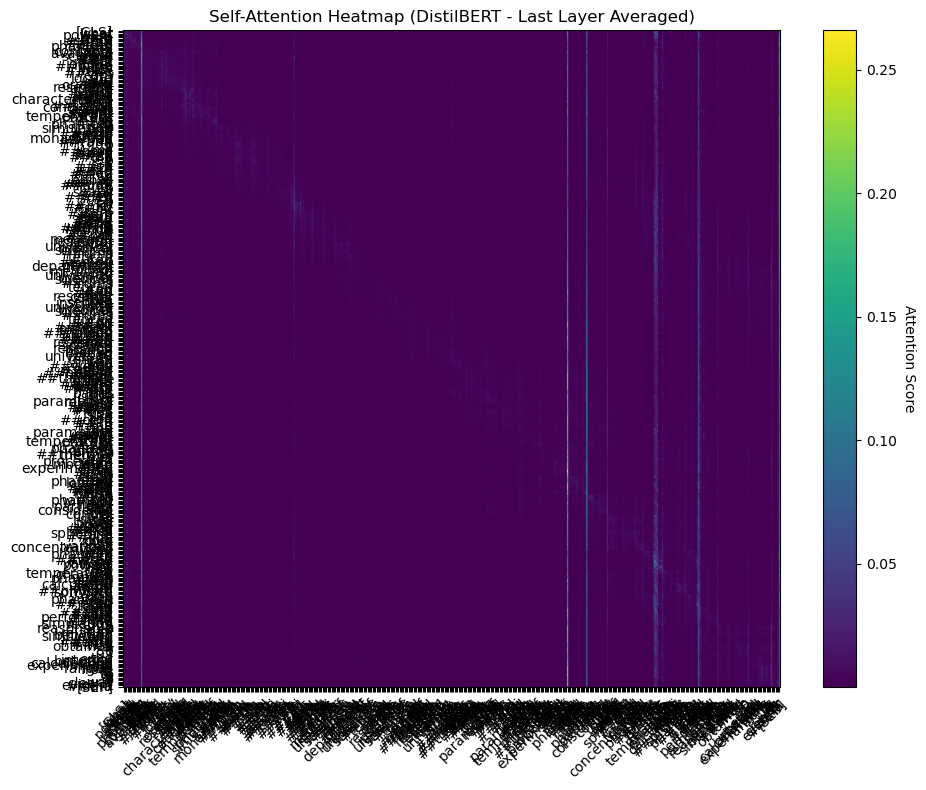

In [35]:
# --- Visualización de Atención (Extra) ---
import matplotlib.pyplot as plt
import torch
# Asegúrate de tener cargados el tokenizer y el modelo de DistilBERT 
# (puedes recargarlos o usar los que ya tienes en memoria si la celda anterior los definió)
from transformers import AutoTokenizer, AutoModelForQuestionAnswering 
import numpy as np

# --- 1. Recargar Modelo con output_attentions=True ---
MODEL_NAME_DISTILBERT_VIZ = 'distilbert-base-uncased-distilled-squad' 
tokenizer_viz = AutoTokenizer.from_pretrained(MODEL_NAME_DISTILBERT_VIZ)
# IMPORTANTE: Cargar el modelo base para obtener las atenciones, no el de QA directamente, 
# o cargar el de QA con output_attentions=True
model_viz = AutoModelForQuestionAnswering.from_pretrained(
    MODEL_NAME_DISTILBERT_VIZ, 
    output_attentions=True # <-- Pedir los pesos de atención
)
model_viz.eval()
device = torch.device("cpu") # Forzar CPU
model_viz.to(device)

# --- 2. Seleccionar una Pregunta y Contexto Corto para Visualizar ---
# (Usa un contexto corto para que el heatmap sea legible)
question_to_viz = QUESTIONS_ANSWERS[4]['question'] 

print(question_to_viz)

# Tomamos solo los primeros ~300 caracteres del contexto para el ejemplo
context_short = ARTICLE_CONTEXT[:] if ARTICLE_CONTEXT else "Example context if PDF failed." 

# --- 3. Obtener los Pesos de Atención ---
inputs_viz = tokenizer_viz(question_to_viz, context_short, return_tensors='pt', truncation=True).to(device)
with torch.no_grad():
    outputs_viz = model_viz(**inputs_viz)

# 'attentions' es una tupla: (capa_1_atencion, capa_2_atencion, ...)
# Cada elemento tiene shape [batch_size, num_heads, seq_length, seq_length]
attentions = outputs_viz.attentions # Para DistilBERT esto estará en outputs_viz.attentions o similar

# --- 4. Preparar Datos para Visualización ---
# Vamos a promediar las cabezas de atención de la última capa para simplificar
last_layer_attentions = attentions[-1] # Última capa
attention_matrix = torch.mean(last_layer_attentions[0], dim=0).cpu().numpy() # Promedio de cabezas, batch 0

# Obtener los tokens para las etiquetas del heatmap
tokens = tokenizer_viz.convert_ids_to_tokens(inputs_viz['input_ids'][0])

# --- 5. Crear el Heatmap con Matplotlib ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attention_matrix, cmap='viridis')

# Configuraciones del gráfico
ax.set_xticks(np.arange(len(tokens)))
ax.set_yticks(np.arange(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)

# Rotar etiquetas del eje X para legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añadir barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Attention Score", rotation=-90, va="bottom")

ax.set_title("Self-Attention Heatmap (DistilBERT - Last Layer Averaged)")
fig.tight_layout()
plt.show()

In [34]:
len(ARTICLE_CONTEXT[:])

35036